## Классификация изображений художников разного стиля с использованием `PyTorch`

### Первая часть задания: создание архитектуры классификации изображений с использованием `PyTorch`

Импорт библиотек:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
#import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict # to check distribution by classes
from sklearn.metrics import precision_recall_fscore_support # to calculate F1 score
from sklearn.model_selection import StratifiedShuffleSplit # to split images to train, val, and test
import numpy as np
import pandas as pd
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\elena\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Определяем трансформацию изображений: отдельно для тренировочного набора с аугментацией данных и отдельно для тестового и валидационного.

In [2]:
# define default transormation

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
#     transforms.RandomGrayscale(p=0.2),
    transforms.RandomRotation(30),
    #transforms.GaussianNoise(0.1),

    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Normalize()
    #transforms.Normalize(mean, std)

])

In [5]:
print(val_transform)
train_transform

Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Загрузка изображений, которые хранятся в директории `images` 

In [6]:
image_dataset = torchvision.datasets.ImageFolder('images', transform=val_transform)
print(len(image_dataset))
print(image_dataset.transform)
image_classes = image_dataset.classes
print(image_classes)

1422
Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
['ArtDeco', 'Cubism', 'Impressionism', 'Japonism', 'Naturalism', 'Rococo', 'cartoon', 'photo']


In [ ]:
# print(image_dataset.targets)


Разбиваем изображения на трейновый, валидационный и тестовый набор (70%, 20%, 10%) без стратификации. Оказалось, что это работает хуже чем со стратификацией с учетом размеров классов. Поэтому закоментировано

In [ ]:
# train_size = int(0.7 * len(image_dataset))
# val_size = int(0.2 * len(image_dataset))
# test_size = len(image_dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size])
# # realize data augmentation for train set
# train_dataset.dataset.transform = train_transform


In [ ]:
# print("Train set size: {:}, validation set size: {:}, test set size: {:}".format(train_size, val_size, test_size))

# print(train_size)
# print(val_size)
# print(test_size)
# print(train_dataset.dataset)

In [ ]:
# загрузка данных соответствующего размера
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Разбиваем изображения на трейновый, валидационный и тестовый набор с учетом размеров классов. Такое разбиение позволяет учитывать несбалансированность классов, которая у нас присутствует. Таким образом, от каждого класса будет использовано 70% в трейновом датасете, 

In [7]:
# from sklearn.model_selection import StratifiedShuffleSplit

# Get the labels for each image
# labels = [image_dataset[i][1] for i in range(len(image_dataset))]
labels = [label for _, label in image_dataset]

# Create the stratified shuffle split object
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=2)

# Split the indices of the images into train and validation-test sets
train_index, test_valid_index = next(split.split(range(len(image_dataset)), labels))
train_dataset = torch.utils.data.Subset(image_dataset, train_index)
test_valid_dataset = torch.utils.data.Subset(image_dataset, test_valid_index)

# for train_index, test_valid_index in split.split(range(len(image_dataset)), labels):
#     train_dataset = torch.utils.data.Subset(image_dataset, train_index)
#     test_valid_dataset = torch.utils.data.Subset(image_dataset, test_valid_index)

# Create a second stratified shuffle split object for the train set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=1)
val_index, test_index = next(split.split(range(len(test_valid_dataset)), [label for _, label in test_valid_dataset]))
test_dataset = torch.utils.data.Subset(test_valid_dataset, test_index)
val_dataset = torch.utils.data.Subset(test_valid_dataset, val_index)

# Split the indices of the train set into train and validation sets
# for val_index, test_index in split.split(range(len(test_valid_dataset)), [test_valid_dataset[i][1] for i in range(len(test_valid_dataset))]):
#     test_dataset = torch.utils.data.Subset(test_valid_dataset, test_index)
#     val_dataset = torch.utils.data.Subset(test_valid_dataset, val_index)


In [8]:
# загрузка данных соответствующего размера
train_dataset.dataset.transform = train_transform
# print(train_dataset.dataset)
batch_size = 32 # определяем размер батча
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
print(train_dataset.dataset.transform) # проверяем трансформации в трейновом датасете
print(test_dataset.dataset.transform)
# print(test_dataloader.dataset.dataset.transform) # проверяем трансформации в тестовом датасете

# print(val_dataset.indices)
# print(val_dataset.dataset.transform)
# print(test_dataloader.dataset.transform)
# print(test_dataset.dataset.transform)
print("Train set size: {:}, validation set size: {:}, test set size: {:}".format(train_index.size, val_index.size, test_index.size))

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


AttributeError: 'Subset' object has no attribute 'transform'

In [ ]:
# from collections import Counter
# image_dataset.indices
# indices = torch.arange(3000)

# Counter(train_dataset.targets[i] for i in indices) 

Проверим результат разбиения по классам

In [10]:
def count_classes(dataloader):
    labels_count = defaultdict(int)
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        for label in labels:
            labels_count[label.item()] += 1
    return(labels_count)

data = {'Train set': count_classes(train_dataloader),
        'Validation set': count_classes(val_dataloader),
        'Test set': count_classes(test_dataloader)}
print(data)

{'Train set': defaultdict(<class 'int'>, {1: 255, 2: 168, 4: 153, 6: 52, 5: 82, 3: 142, 7: 97, 0: 46}), 'Validation set': defaultdict(<class 'int'>, {4: 39, 2: 43, 1: 66, 0: 11, 5: 21, 6: 14, 7: 25, 3: 37}), 'Test set': defaultdict(<class 'int'>, {3: 24, 6: 9, 2: 29, 5: 14, 0: 8, 4: 26, 1: 44, 7: 17})}


Отрисуем результат разбиения по классам на тренировочный, валидационный и тестовый набор

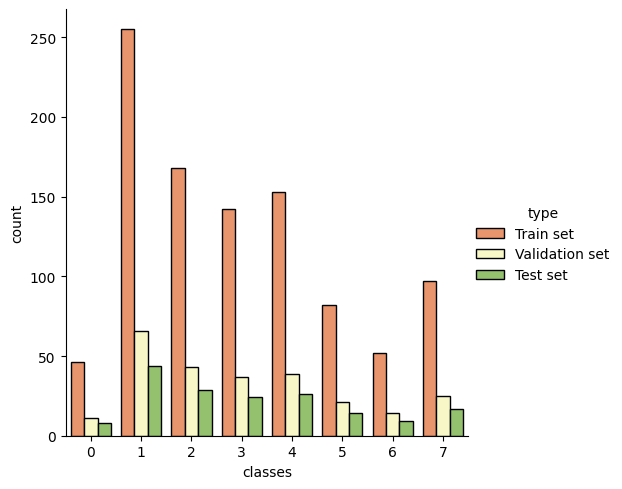

In [11]:
# import seaborn as sns
# import pandas as pd
keys = list(data['Train set'].keys())
train_values = list(data['Train set'].values())
val_values = list(data['Validation set'].values())
test_values = list(data['Test set'].values())

df = pd.DataFrame()
for group, items in data.items():
    temp = pd.DataFrame.from_dict(items, orient='index', columns=[group])
    df = pd.concat([df, temp], axis=1, sort=False)

# преобразуем данные в длинный формат для построения графика

df = df.reset_index().melt(id_vars='index', value_vars=list(data.keys()), value_name='count', var_name='type')
df.rename(columns={'index': 'classes'}, inplace=True)

sns.catplot(x="classes", y="count", kind="bar", hue = 'type', 
            data=df, dodge=True, edgecolor = 'black', palette=sns.color_palette(['#fc8d59', '#ffffbf', '#91cf60']))

plt.show()


Определяем функцию для отрисовки изображений с лейблами

In [12]:
def showimages(imgs,actual_lbls,pred_lbls=None):
  
  fig = plt.figure(figsize=(21,12))

  for i,img in enumerate(imgs):
    
    fig.add_subplot(4,8, i+1)
    y=actual_lbls[i]
    
    if pred_lbls!=None:
      y_pre=pred_lbls[i]
      title="prediction: {0}\nlabel:{1}".format(image_dataset.classes[y_pre], image_dataset.classes[y])
    else: 
      title="Label: {0}".format(image_dataset.classes[y])

    plt.title(title)
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.axis("off")
    plt.imshow(img)
  
# plt.show()

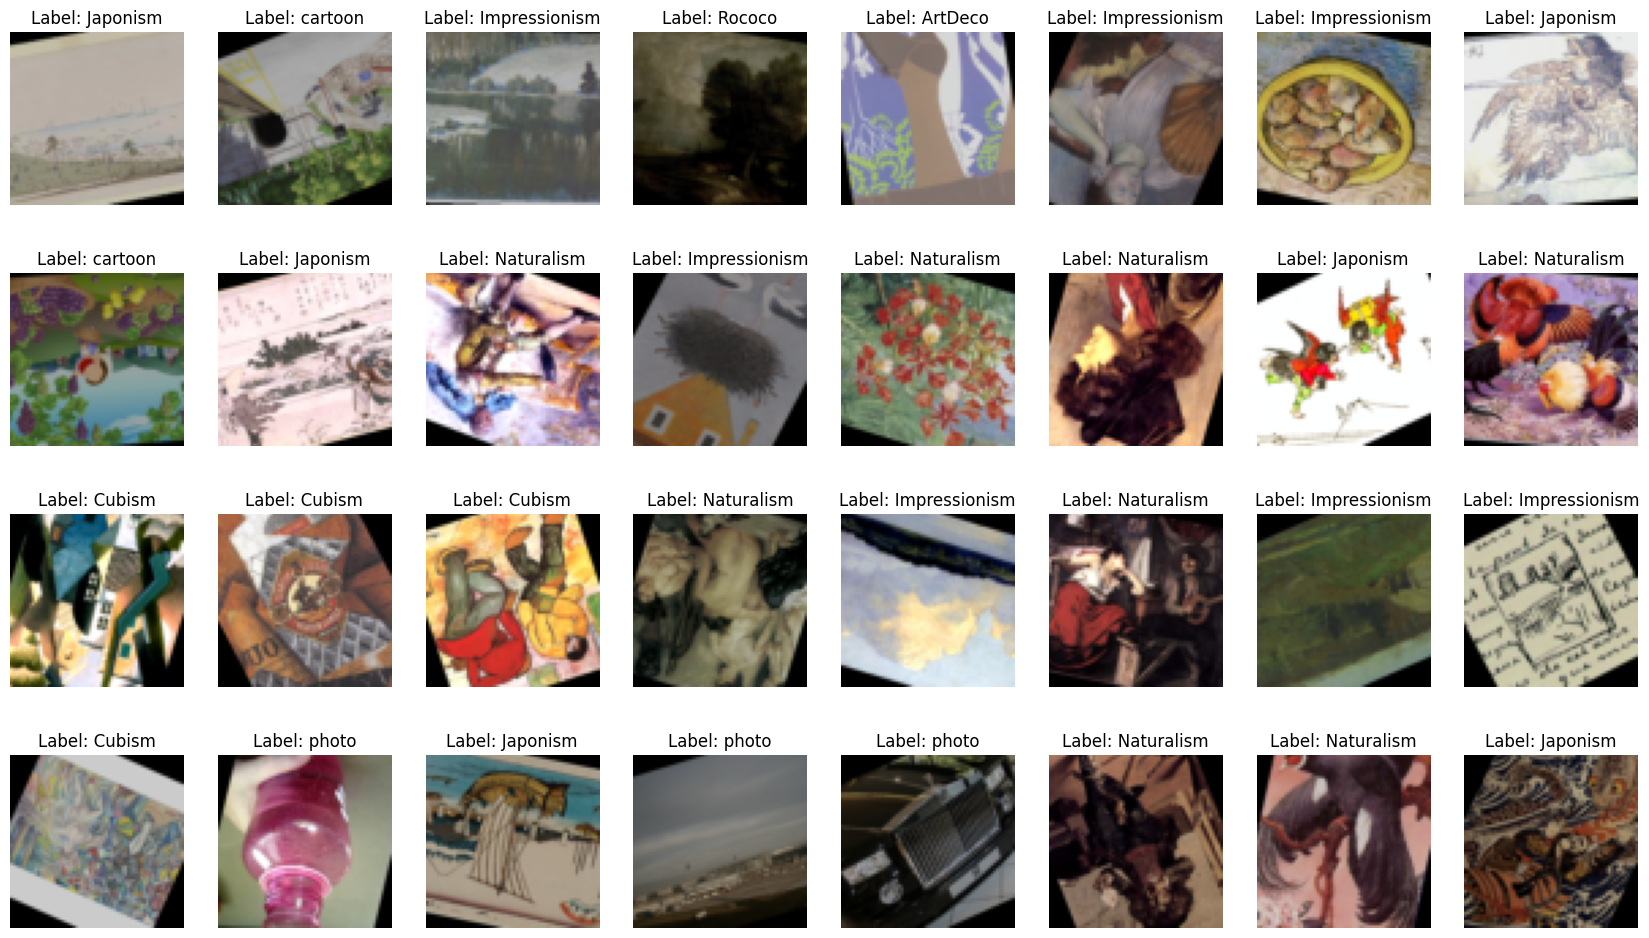

In [13]:
inputs, classes = next(iter(test_dataloader))

showimages(inputs, classes)

Определяем модель для классификации изображений: resnet с 18 слоями, задаем на полносвязном уровне количество наших классов 

In [11]:
model = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
#model = torchvision.models.resnet50(weights=True)

model.fc = nn.Linear(512, len(image_dataset.classes))
# model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))
#model.fc.register_forward_hook(lambda m, inp, out: nn.Softmax(out))
#model.fc = nn.Sequential(
 #   nn.Linear(512, len(image_dataset.classes)),
  #  nn.Softmax())
#model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))


Выбираем функцию ошибки CrossEntropyLoss, поскольку у нас задача классификации нескольких классов. Например, можно почитать об этом [здесь](https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451), [здесь](https://gombru.github.io/2018/05/23/cross_entropy_loss/). 
Использование стохастического градиентного спуска показало самый лучший результат в этой задаче


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.RMSprop(model.parameters()) # this optimizer functioned really bad

In [13]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
f1_scores = []

In [14]:
print(test_dataloader.dataset.indices)

[236 124 421 399 379 197 117 151 348 108 152  68  29 113  79 260 232  91
 156 333  51   7 226 365  76 158 262 336 229 120 170 249 366  58  24 133
 313 339 295 374 420 263  81 244 388 252  45 149 308 426  60 150  17 354
 328  13 403  96 157 391 386 142 418 344 360 171  25 125 345 141 144 416
 371 247 115 302 184 225 216 227  38   5 162 160 202 105 238 126 259 316
 361  10 310 275 422  32 284  52   4 212 383 131 285 248 409 377   3 299
  31 281  40 190 274  50 176 293 209  93 172 370  59 321 305 192 340  44
 286  65 245 123 191  63  22  83 234 389 214 276 153  33 237 406  42 322
 392  19 243 203 307 181 208 164 173  23 373 320 424  67 405  27 375 417
  11 277  95  41 367 189 337 349 239]


Задаем функцию для проверки валидационного и тестого сета, чтобы не дублировать код

In [15]:
# from sklearn.metrics import precision_recall_fscore_support

def validate(curr_model, dataloader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        total = 0
        correct = 0
        confusion_matrix = torch.zeros(len(image_dataset.classes), len(image_dataset.classes), dtype=torch.int64)
        true_labels = []
        pred_labels = []

        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = curr_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            true_labels.extend(labels.tolist())
            pred_labels.extend(preds.tolist())

            for t, p in zip(labels, preds):
                confusion_matrix[t, p] += 1

        val_loss = running_loss / len(dataloader)
        val_accuracy = 100 * correct / total

        precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
        precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro', zero_division=0)
#         print(f1_score)
    print('Precision {:.2f}, recall {:.2f}'.format(precision, recall))
    return val_loss, val_accuracy, f1_score, f1_score_macro



In [16]:
num_epochs = 20

best_accuracy = 0
best_loss = float('inf')
best_epoch = 0
best_f1_score = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate the average loss and accuracy for the epoch
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate the model
    val_loss, val_accuracy, f1_score, f1_score_macro = validate(model, val_dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    f1_scores.append(f1_score)

    print("Epoch {}/{} - Train Loss: {:.4f} - Train Accuracy: {:.2f}% - Val Loss: {:.4f} - Val Accuracy: {:.4f}%, f1_score {:.4f} f1_macro {:.4f}".format(
        epoch + 1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy, f1_score, f1_score_macro))
#     if f1_score > best_f1_score:
#         best_f1_score = f1_score
    if epoch >= 5 and (val_loss < best_loss or f1_score > best_f1_score):
        best_loss = val_loss
#         best_accuracy = val_accuracy
        best_f1_score = f1_score
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model_wthout_augm.pt')

Precision 0.38, recall 0.43
Epoch 1/20 - Train Loss: 1.9979 - Train Accuracy: 28.54% - Val Loss: 1.6366 - Val Accuracy: 42.5781%, f1_score 0.3867 f1_macro 0.2891
Precision 0.46, recall 0.48
Epoch 2/20 - Train Loss: 1.5244 - Train Accuracy: 47.04% - Val Loss: 1.5640 - Val Accuracy: 48.0469%, f1_score 0.4585 f1_macro 0.3802
Precision 0.50, recall 0.47
Epoch 3/20 - Train Loss: 1.3586 - Train Accuracy: 54.27% - Val Loss: 1.5398 - Val Accuracy: 46.8750%, f1_score 0.4553 f1_macro 0.4056
Precision 0.45, recall 0.47
Epoch 4/20 - Train Loss: 1.2203 - Train Accuracy: 57.89% - Val Loss: 1.4247 - Val Accuracy: 46.8750%, f1_score 0.4474 f1_macro 0.3873
Precision 0.55, recall 0.54
Epoch 5/20 - Train Loss: 1.0476 - Train Accuracy: 63.12% - Val Loss: 1.3554 - Val Accuracy: 54.2969%, f1_score 0.5398 f1_macro 0.5054
Precision 0.53, recall 0.54
Epoch 6/20 - Train Loss: 1.0084 - Train Accuracy: 64.72% - Val Loss: 1.4149 - Val Accuracy: 53.5156%, f1_score 0.5217 f1_macro 0.4667
Precision 0.58, recall 0.57


In [17]:
# 'best_model' + str(best_epoch), '.pt'

('best_model18', '.pt')

In [24]:
# print(f1_scores)
print(best_f1_score)
best_epoch

0.5982927269185304


19

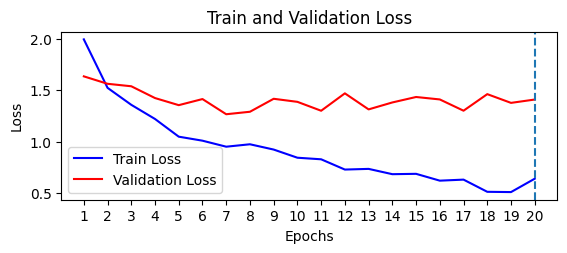

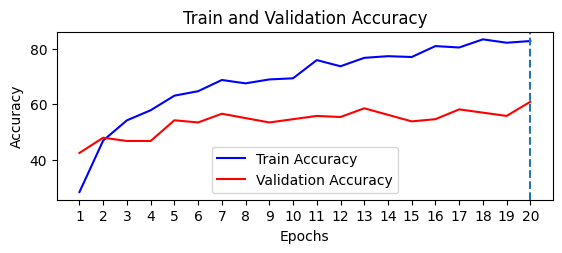

In [25]:
epochs = range(1, num_epochs + 1)
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.axvline(x = best_epoch+1, linestyle = '--')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xticks(range(1, num_epochs+1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.axvline(x = best_epoch+1, linestyle = '--')
plt.show()


#plt.plt(train_losses, val_losses)

Похоже модель сходится

In [19]:
import numpy as np
print(val_index.size)
print(train_index.size)

train_val = np.concatenate((train_index, val_index), axis=0)
print(train_val)

256
995
[339 434 577 ... 204 118 342]


In [ ]:
# print(val_dataset.indices)
# print(train_val_dataset.indices)

In [ ]:
# загрузка данных соответствующего размера
train_val_dataset = torch.utils.data.Subset(image_dataset, train_val)

train_val_dataset.dataset.transform = train_transform
print(train_val_dataset.dataset)
# batch_size = 16
train_val_dataloader = torch.utils.data.DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = torchvision.models.resnet18(weights=True)
#model = torchvision.models.resnet50(weights=True)

model.fc = nn.Linear(512, len(image_dataset.classes))

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
f1_scores = []

In [ ]:
num_epochs = 14

best_accuracy = 0
best_loss = float('inf')
# best_epoch = 0
best_f1_score = 0
f1_score = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate the average loss and accuracy for the epoch
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate the model
#     val_loss, val_accuracy, f1_score, f1_score_macro = validate(model, val_dataloader, criterion)
#     val_losses.append(val_loss)
#     val_accuracies.append(val_accuracy)
#     f1_scores.append(f1_score)

    print("Epoch {}/{} - Train Loss: {:.4f} - Train Accuracy: {:.2f}% ".format(
        epoch + 1, num_epochs, train_loss, train_accuracy))
#     if f1_score > best_f1_score:
#         best_f1_score = f1_score
#     if val_loss < best_loss:
#         best_loss = val_loss
#         best_loss = val_loss
#         best_epoch = epoch
        

In [ ]:
# torch.save(model.state_dict(), 'best_model_last_state.pt')

In [23]:
model.load_state_dict(torch.load('best_model_wthout_augm.pt'))


<All keys matched successfully>

In [26]:
# best_model = models.resnet.ResNet(...)
# model.load_state_dict(torch.load('best_model_feature_val.pt'))
# print(model)
test_loss, test_accuracy, test_f1_score, macro_f1_score = validate(model, test_dataloader, criterion)
print(best_epoch+1)
print("Test Loss: {:.4f}, Test Accuracy: {:.2f} in the epoch {:} \nF1 weighted {:.4f} F1 macro {:.4f}".format(test_loss, test_accuracy, best_epoch+1, test_f1_score, macro_f1_score))

Precision 0.58, recall 0.56
20
Test Loss: 1.4765, Test Accuracy: 56.14 in the epoch 20 
F1 weighted 0.5591 F1 macro 0.5427


In [ ]:
# print(model)
# type(best_model)
# type(model)
# print(best_model.__class_)

Тестируем качество нашей модели на тестовой выборке. Вычисляем точность и F-score

In [27]:
test_loss, test_accuracy, test_f1_score, macro_f1_score = validate(model, test_dataloader, criterion)
print(best_epoch+1)
print("Test Loss: {:.4f}, Test Accuracy: {:.2f} in the epoch {:} \nF1 weighted {:.4f} F1 macro {:.4f}".format(test_loss, test_accuracy, best_epoch+1, test_f1_score, macro_f1_score))
# Initialize the confusion matrix

confusion_matrix = torch.zeros(len(image_dataset.classes), len(image_dataset.classes), dtype=torch.int64)

# Initialize the lists to store the true labels and predicted labels for the test set
true_labels = []
pred_labels = []

# Evaluation mode
model.eval()

# Set the gradient computation to be off
with torch.no_grad():
    # Iterate over the test data
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        
        # Append the true labels and predicted labels to the lists
        true_labels.extend(labels.tolist())
        pred_labels.extend(preds.tolist())
        
        # Increment the count in the corresponding cells of the confusion matrix
        for t, p in zip(labels, preds):
            confusion_matrix[t, p] += 1

# Compute the precision, recall and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro')

# Print the test loss, test accuracy and f1-score
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%, Weighted test F1-Score: {:.2f}, macro F1-score {:.2f}".format(test_loss, test_accuracy, f1_score, f1_score_macro))
# print("Macro Test Loss: {:.4f} - Test Accuracy: {:.2f}% - Test F1-Score: {:.2f}".format(test_loss, test_accuracy, f1_score_macro))

Precision 0.57, recall 0.56
20
Test Loss: 1.5207, Test Accuracy: 56.14 in the epoch 20 
F1 weighted 0.5547 F1 macro 0.5178
Test Loss: 1.5207, Test Accuracy: 56.14%, Weighted test F1-Score: 0.54, macro F1-score 0.51


In [28]:
confusion_matrix

tensor([[ 2,  3,  0,  0,  2,  0,  0,  1],
        [ 0, 30,  4,  5,  4,  0,  0,  1],
        [ 0,  3, 18,  2,  6,  0,  0,  0],
        [ 1,  3,  2, 12,  3,  2,  1,  0],
        [ 0,  4,  4,  2, 13,  2,  0,  1],
        [ 0,  1,  2,  1,  3,  6,  0,  1],
        [ 0,  2,  0,  0,  1,  1,  4,  1],
        [ 0,  3,  0,  0,  4,  3,  0,  7]])

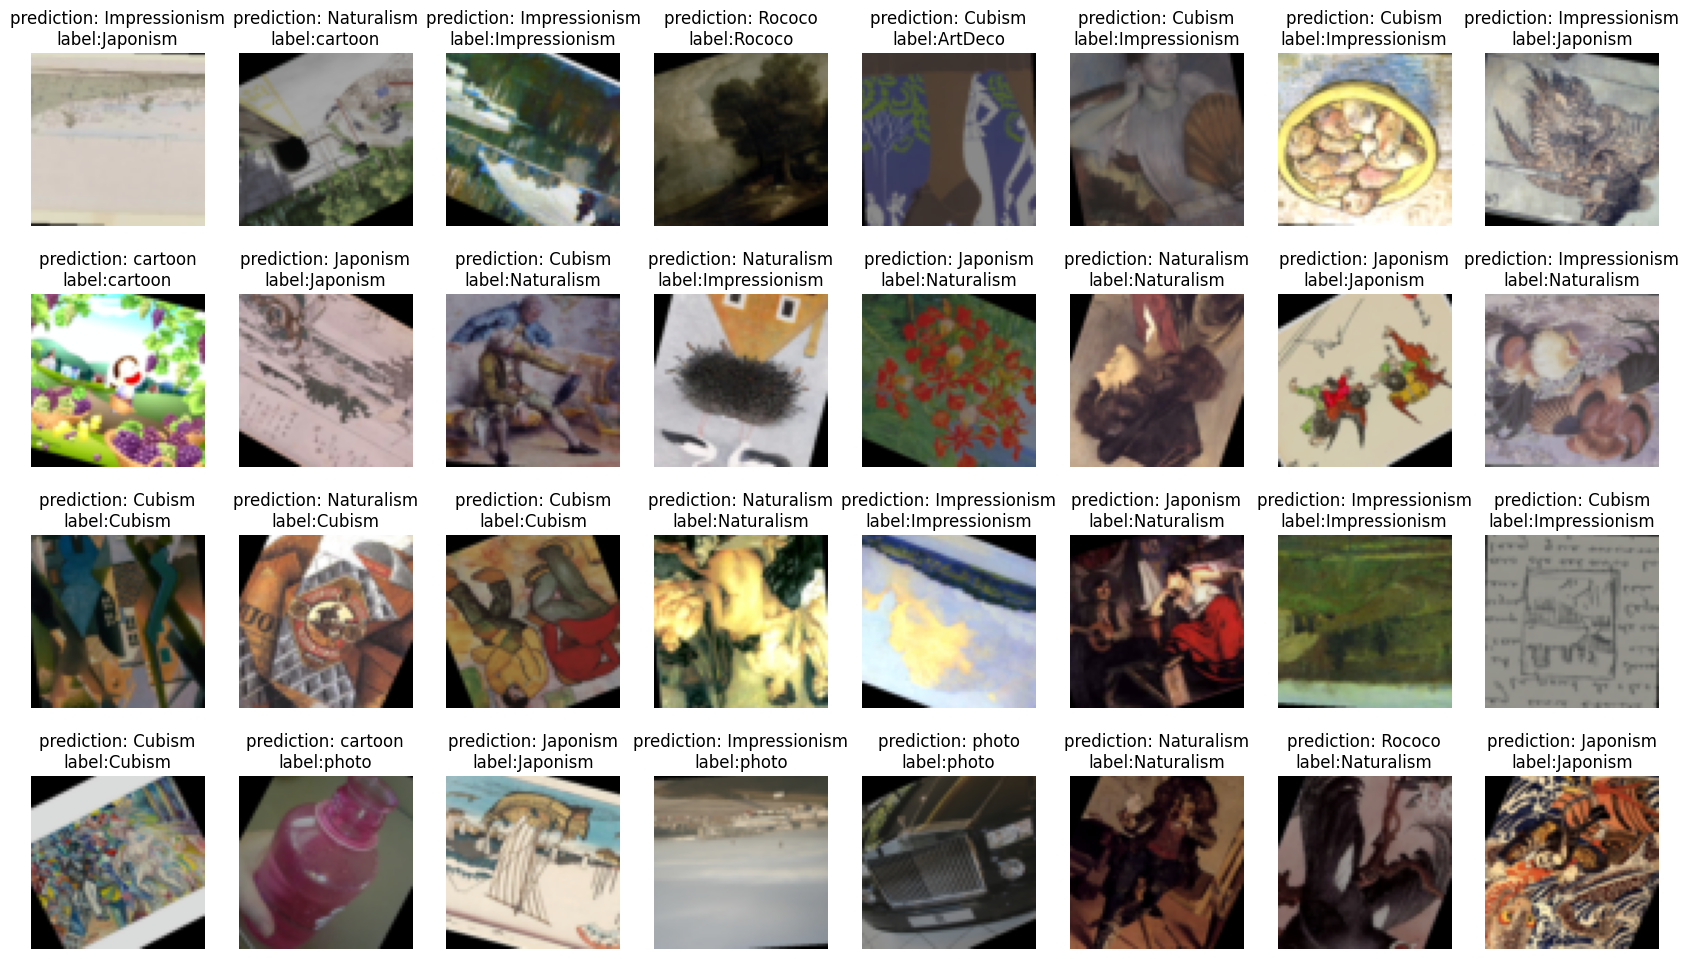

In [29]:
def predict_images(model,images,actual_label):
  model.eval()
  with torch.no_grad():
    inputs = images.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    showimages(images, actual_label, preds.cpu())
    

images, classes = next(iter(test_dataloader))

predict_images(model,images,classes)

In [34]:
print(precision)
print(recall)

0.534542469944132
0.5380116959064327


In [ ]:
print(train_losses)
print(train_accuracies)
print(val_losses)
print(val_accuracies)